# Predicting NHL Players’ Future Scoring Consistency From Performance Statistics
**Author:** Anthony Mitine – Drop the Mitts \
**Course:** COGS 118B. Introduction to Machine Learning \
**Date:** December 11, 2025

## Overview
This project develops a machine learning pipeline to forecast NHL player performance. We aggregate NHL player statistics from 2010–2024 using MoneyPuck data.
1.  **Data Processing**: We standardize metrics to "Per 60 Minute" rates to fairly compare first-liners with fourth-liners. We include all game situations (5v5, Power Play, Penalty Kill) to capture a player's full utility.
2.  **Unsupervised Learning**: We use **K-Means Clustering** to group players into "Style Clusters" (e.g., Snipers, Playmakers, Grinders). We visualize these clusters using Radar Charts to ensure they are statistically distinct.
3. **Supervised Learning**: We train **Random Forest Regressors** to predict future performance. We perform an A/B test to see if including the "Cluster ID" as a feature improves prediction accuracy compared to a baseline model.
4. **Segmentation**: Predictions for the 2025 season are segmented by player experience (Rookies, Mid-Career, Veterans) to account for different development curves.

**Link to Presentation:** https://docs.google.com/presentation/d/1oiNJJV0P1-MUvAAKngwO8wRMM_j1hxMUhJyjfMScZQI/edit?usp=sharing

**Link to Video:** https://drive.google.com/file/d/1DeGUEP6_3OQQvnirYF59IA_Z6KrIEUiO/view?usp=sharing

**Data Source:** [MoneyPuck.com](https://www.moneypuck.com/data.htm) (2010 – 2025) \
This model utilizes NHL data exclusively. While including AHL, NCAA, or KHL statistics would improve predictions for Rookies (1-3 years experience), no public API currently exists to aggregate these leagues reliability without paid subscriptions. Due to this, Rookie predictions in this model rely on their limited NHL sample size.

In [1]:
# Importing all needed libraries
import pandas as pd
import numpy as np
import requests
import io
import matplotlib.pyplot as plt
import seaborn as sns
from math import pi
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

# Visualization settings
sns.set_theme(style="whitegrid", context="talk")
pd.set_option('display.max_columns', None)

## 1. Data Loading

We download regular season skater data from **MoneyPuck.com** for seasons 2010 through 2024. This provides a historical dataset for training our models.

In [2]:
# Download/Load Data (2010 - Present)
frames = []
print("Downloading Data...")
for year in range(2010, 2025):
    url = f"https://www.moneypuck.com/moneypuck/playerData/seasonSummary/{year}/regular/skaters.csv"
    try:
        s = requests.get(url).content
        df = pd.read_csv(io.StringIO(s.decode('utf-8')))
        df['season'] = year
        frames.append(df)
        print(f" - Loaded {year}-{year+1}")
    except:
        print(f" ! Failed to load {year}")

df_raw = pd.concat(frames, ignore_index=True)
print(f"Data Loaded. Total Rows: {len(df_raw)}")

 - Loaded 2010-2011
 - Loaded 2011-2012
 - Loaded 2012-2013
 - Loaded 2013-2014
 - Loaded 2014-2015
 - Loaded 2015-2016
 - Loaded 2016-2017
 - Loaded 2017-2018
 - Loaded 2018-2019
 - Loaded 2019-2020
 - Loaded 2020-2021
 - Loaded 2021-2022
 - Loaded 2022-2023
 - Loaded 2023-2024
 - Loaded 2024-2025
Data Loaded. Total Rows: 67835


## 2.Data Engineering

Here we transform the raw data into a machine-learning-ready format.
* **Situational Filtering**: We extract data for **All Situations**, **5 on 5**, **5 on 4** (Power Play), and **4 on 5** (Penalty Kill) to get a complete picture of player usage.

* **Pivoting**: We convert the data from "Long" format (multiple rows per player) to "Wide" format (one row per player-season).

* **Rate Statistics**: We normalize all counting statistis (Goals, Assists) to **Per 60 Minute** rates to signify the time of one NHL game.

* **Experience Calculation**: We calculate **Years_Exp** (Years of Experience) to enable our segmented predictions later.

* **Target Creation**: We align **Season X** stats with **Season X+1** results to create the prediction target.

In [3]:
# Filter Situations (Expanded to include PP and PK)
# We grab 'all', '5on5', '5on4' (PowerPlay), '4on5' (PenaltyKill)
target_situations = ['all', '5on5', '5on4', '4on5']
df_filtered = df_raw[df_raw['situation'].isin(target_situations)].copy()

# Pivot to Wide Format
metrics = ['I_F_goals', 'I_F_primaryAssists', 'I_F_points', 'I_F_hits','shotsBlockedByPlayer', 'icetime', 'I_F_xGoals', 'I_F_shotAttempts']

df_pivot = df_filtered.pivot_table(index=['playerId', 'season', 'name', 'team', 'position'], columns='situation', values=metrics, aggfunc='sum')

# Flatten columns
df_pivot.columns = [f"{sit}_{stat.replace('I_F_', '').replace('shotsBlockedByPlayer', 'blocks')}" for stat, sit in df_pivot.columns]
df_pivot.reset_index(inplace=True)

# Create Rate Stats (Per 60 Mins)
df_pivot['all_assists'] = df_pivot['all_points'] - df_pivot['all_goals']
df_pivot['all_icetime_mins'] = df_pivot['all_icetime'] / 60

# We use Per 60 rates for fair comparison
df_pivot['all_goals_p60'] = (df_pivot['all_goals'] / df_pivot['all_icetime']) * 3600
df_pivot['all_assists_p60'] = (df_pivot['all_assists'] / df_pivot['all_icetime']) * 3600
df_pivot['all_points_p60'] = (df_pivot['all_points'] / df_pivot['all_icetime']) * 3600
df_pivot['5on5_xGoals_p60'] = (df_pivot['5on5_xGoals'] / df_pivot['5on5_icetime']) * 3600
df_pivot['5on4_points_p60'] = (df_pivot['5on4_points'] / df_pivot['5on4_icetime']) * 3600
df_pivot['all_hits_p60'] = (df_pivot['all_hits'] / df_pivot['all_icetime']) * 3600
df_pivot['all_blocks_p60'] = (df_pivot['all_blocks'] / df_pivot['all_icetime']) * 3600
df_pivot['all_shots_p60'] = (df_pivot['all_shotAttempts'] / df_pivot['all_icetime']) * 3600

# Handle NaNs
df_pivot.fillna(0, inplace=True)

# Calculate Years of Experience
df_pivot = df_pivot.sort_values(['playerId', 'season'])
df_pivot['Years_Exp'] = df_pivot.groupby('playerId').cumcount() + 1

# Filter Noise (>300 mins)
df_clean = df_pivot[df_pivot['all_icetime'] > (300 * 60)].copy()

# Create Targets (Shift Back 1 Year)
df_future = df_clean[['name', 'season', 'all_goals_p60', 'all_assists_p60']].copy()
df_future['season'] = df_future['season'] - 1 
df_future.rename(columns={
    'all_goals_p60': 'Target_NextYear_Goals_p60',
    'all_assists_p60': 'Target_NextYear_Assists_p60'
}, inplace=True)

# Merge
df_supervised = pd.merge(df_clean, df_future, on=['name', 'season'], how='inner')

print(f"Training Examples: {len(df_supervised)}")

Training Examples: 7509


## 3. Unsupervised Learning (Player Clustering)
We group players into 5 distinct Clusters based on their playstyle (Shooting, Passing, Hitting, Powerplay usage).

* **Method**: K-Means Clustering on standardized style metrics.

* **Visual**: A Radar Chart is used to visualize the "make-up" of each cluster, showing which stats (Hits, Goals, Assists) dominate that group.

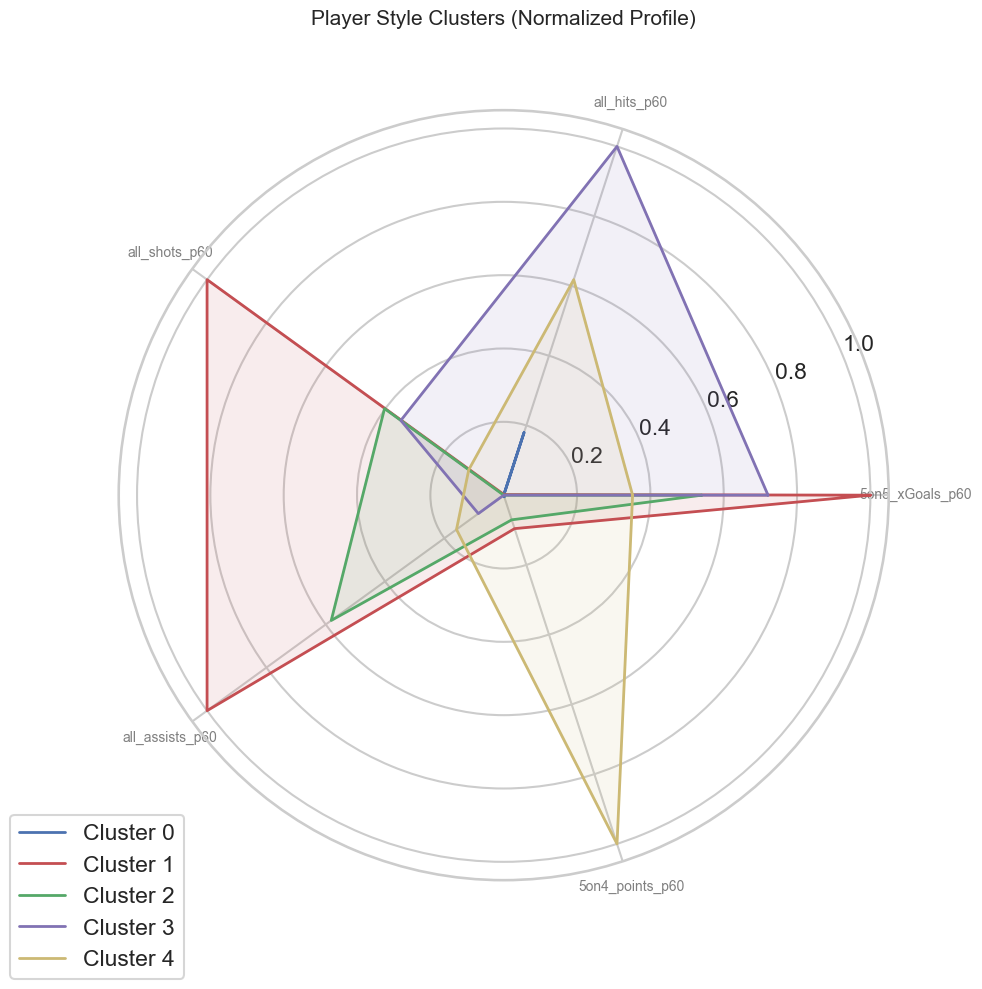

--- Cluster Descriptions ---
Cluster 0: Dominant trait is all_hits_p60
Cluster 1: Dominant trait is 5on5_xGoals_p60
Cluster 2: Dominant trait is all_assists_p60
Cluster 3: Dominant trait is all_hits_p60
Cluster 4: Dominant trait is 5on4_points_p60


In [4]:
# Setup Data for Clustering
# We use a mix of 5v5, PowerPlay, and Physical stats to define style
cluster_features = ['5on5_xGoals_p60', 'all_hits_p60', 'all_shots_p60', 'all_assists_p60', '5on4_points_p60']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_supervised[cluster_features])

# Apply K=5
kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
df_supervised['Cluster'] = kmeans.fit_predict(X_scaled)

# Cluster Interpretation
cluster_means = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_), columns=cluster_features)
cluster_means['Cluster'] = range(5)

# Function to create Radar Chart
def make_radar(df, title):
    categories = list(df)[0:-1]
    N = len(categories)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]
    
    plt.figure(figsize=(10, 10))
    ax = plt.subplot(111, polar=True)
    plt.xticks(angles[:-1], categories, color='grey', size=10)
    
    # Scale data for visualization
    df_norm = (df - df.min()) / (df.max() - df.min())
    df_norm['Cluster'] = df['Cluster']

    colors = ['b', 'r', 'g', 'm', 'y']
    for i, row in df_norm.iterrows():
        values = row.drop('Cluster').values.flatten().tolist()
        values += values[:1]
        ax.plot(angles, values, linewidth=2, linestyle='solid', label=f"Cluster {int(row['Cluster'])}", color=colors[i])
        ax.fill(angles, values, color=colors[i], alpha=0.1)
    
    plt.title(title, size=15, y=1.1)
    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
    plt.show()

make_radar(cluster_means, "Player Style Clusters (Normalized Profile)")

print("--- Cluster Descriptions ---")

# Create a normalized version of the means (just for the description logic)
# We drop 'Cluster' first so we don't try to normalize the ID number
temp_means = cluster_means.drop('Cluster', axis=1)
normalized_means = (temp_means - temp_means.min()) / (temp_means.max() - temp_means.min())

# Loop through the normalized values to find the dominant trait
for i, row in normalized_means.iterrows():
    top_stat = row.idxmax()
    print(f"Cluster {i}: Dominant trait is {top_stat}")

The clustering algorithm identified five distinct player "styles" based on their statistical DNA. Looking at the radar chart, we can interpret these groups as:

* **Cluster 0 (Blue - "The Low-Event Player")**: These players score low in all selected categories relative to the other groups. They likely have low time-on-ice or are replacement-level players who don't generate significant stats in these specific categories.

* **Cluster 1 (Red - "The Elite Offensive Driver")**: These are our top-line superstars. They drive play, generate high expected goals (xG), and shoot frequently. They are high-event offensive players.
  
* **Cluster 2 (Green - "The Depth / Two-Way Player")**: This cluster is likely made up of Bottom-6 forwards who contribute a bit of everything but don't excel in elite scoring or extreme physicality.

* **Cluster 3 (Purple - "The Physical Specialist")**: These are likely "Energy Line" players or defensive-minded players whose primary contribution is physicality rather than scoring.

* **Cluster 4 (Yellow - "The Power Play Specialists")**: These players might be sheltered at even strength but possess a specific skill set (like a heavy shot or vision) that makes them valuable when up a man.


The data proves that "Style" is mathematically quantifiable. A 50-point scorer who hits everyone (Cluster 3) is fundamentally different from a 50-point scorer who only plays on the Power Play (Cluster 4).

## 4: Model Training & Evaluation (A/B Testing)
We split the data into **Training (2010 - 2023)** and **Validation (2023 inputs -> 2024 targets)**. We train two Random Forest models for both Goals and Assists:

1. **Cluster Model**: Includes the K-Means Cluster ID as a feature.
2. **Plain Model**: Uses only raw statistics.

We evaluate using **MAE** (Mean Absolute Error) and **R²** (Variance Explained).

--- Goals Model Comparison ---
Cluster Model -> MAE: 0.178, R2: 0.692
Plain Model   -> MAE: 0.179, R2: 0.690
Winner: Cluster

--- Assists Model Comparison ---
Cluster Model -> MAE: 0.263, R2: 0.534
Plain Model   -> MAE: 0.263, R2: 0.533
Winner: Cluster



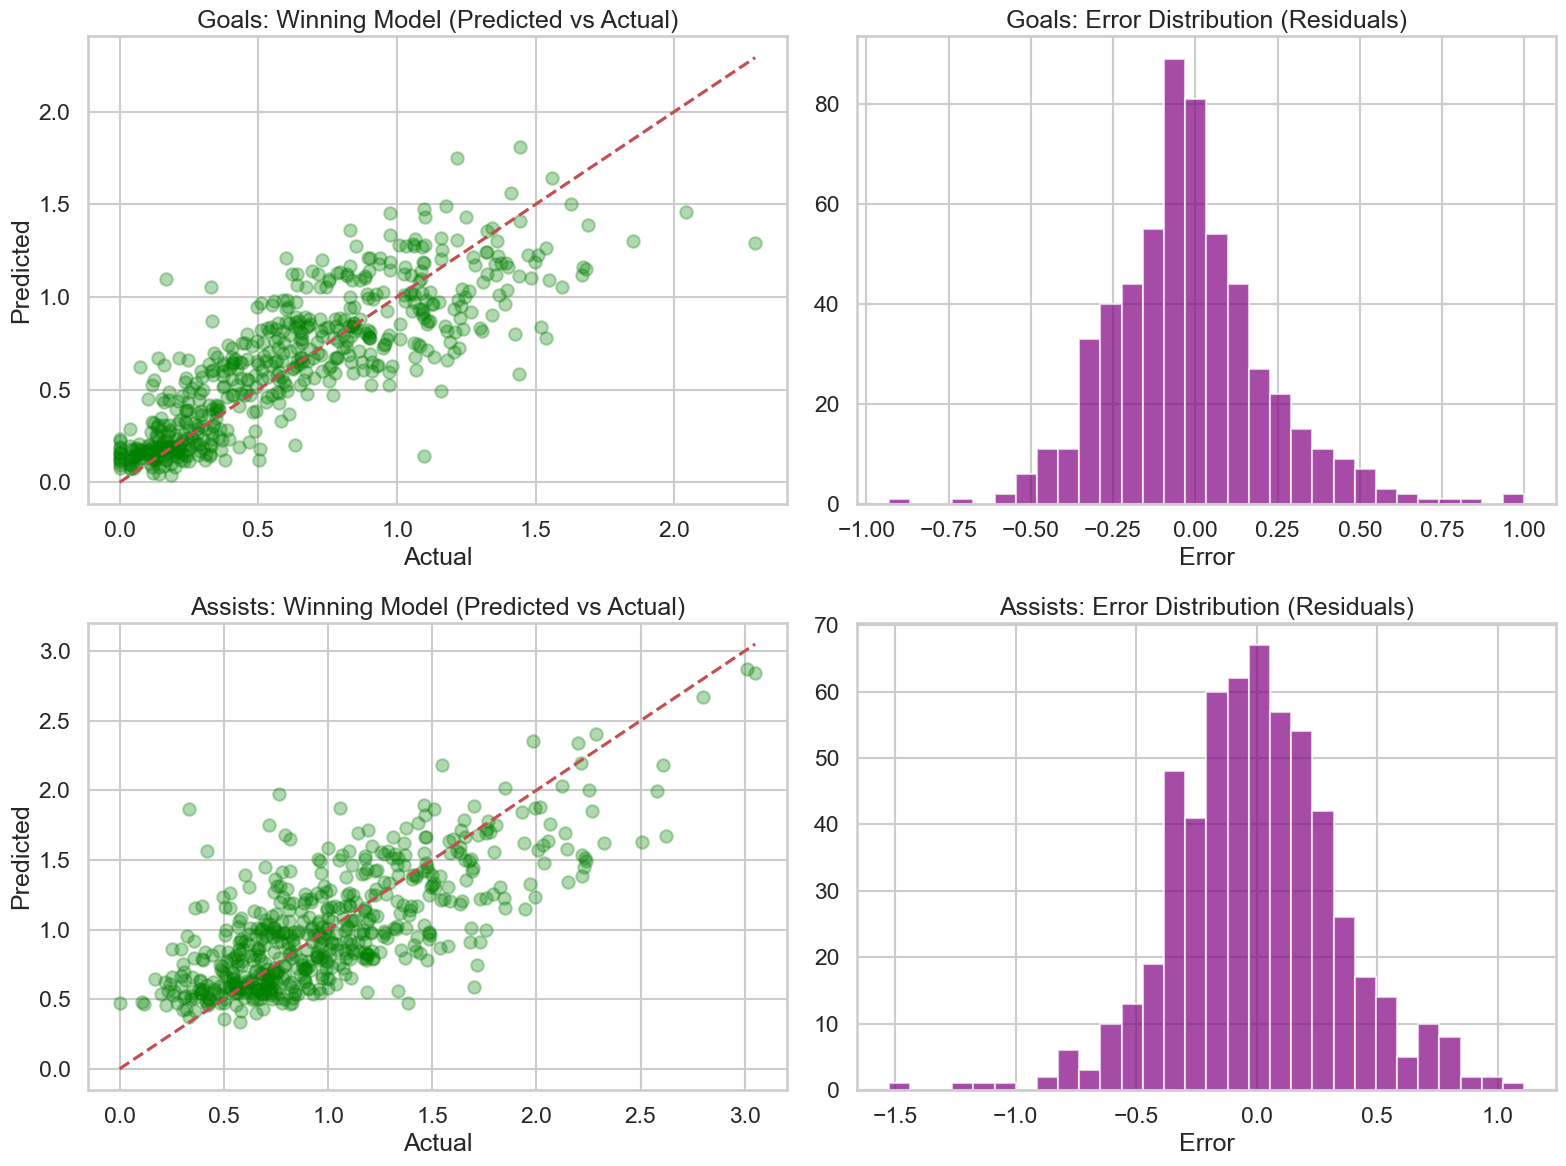

In [5]:
# Validation Year: 2024 Season (Target)
train_years = list(range(2010, 2023))
X_train = df_supervised[df_supervised['season'].isin(train_years)].copy()
X_test = df_supervised[df_supervised['season'] == 2023].copy() 

# Re-scale based on split to prevent leakage
scaler_p1 = StandardScaler()
X_train_scaled = scaler_p1.fit_transform(X_train[cluster_features])
X_test_scaled = scaler_p1.transform(X_test[cluster_features])

kmeans_p1 = KMeans(n_clusters=5, random_state=42, n_init=10)
X_train['Cluster'] = kmeans_p1.fit_predict(X_train_scaled)
X_test['Cluster'] = kmeans_p1.predict(X_test_scaled)

results = {}
targets = ['Target_NextYear_Goals_p60', 'Target_NextYear_Assists_p60']
features_base = ['all_goals_p60', 'all_assists_p60', '5on5_xGoals_p60', 'all_shots_p60', '5on4_points_p60']

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

for i, target in enumerate(targets):
    stat_name = "Goals" if "Goals" in target else "Assists"
    
    # Train Cluster Model
    rf_cluster = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_cluster.fit(X_train[features_base + ['Cluster']], X_train[target])
    preds_cluster = rf_cluster.predict(X_test[features_base + ['Cluster']])
    
    # Train Plain Model
    rf_plain = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_plain.fit(X_train[features_base], X_train[target])
    preds_plain = rf_plain.predict(X_test[features_base])
    
    # Metrics
    metrics_cluster = {'MAE': mean_absolute_error(X_test[target], preds_cluster), 'R2': r2_score(X_test[target], preds_cluster)}
    metrics_plain = {'MAE': mean_absolute_error(X_test[target], preds_plain),'R2': r2_score(X_test[target], preds_plain)}
    
    # Determine Winner (Lowest MAE)
    use_cluster = metrics_cluster['MAE'] < metrics_plain['MAE']
    results[stat_name] = {'use_cluster': use_cluster, 'model': rf_cluster if use_cluster else rf_plain}
    
    print(f"--- {stat_name} Model Comparison ---")
    print(f"Cluster Model -> MAE: {metrics_cluster['MAE']:.3f}, R2: {metrics_cluster['R2']:.3f}")
    print(f"Plain Model   -> MAE: {metrics_plain['MAE']:.3f}, R2: {metrics_plain['R2']:.3f}")
    print(f"Winner: {'Cluster' if use_cluster else 'Plain'}\n")

    # Visuals: Predicted vs Actual
    # Row 1: Goals, Row 2: Assists
    # Col 1: Cluster, Col 2: Plain (Just comparing Best vs Worst for visual clarity)
    
    # Plotting Best Performing Model
    ax = axes[i, 0]
    best_preds = preds_cluster if use_cluster else preds_plain
    ax.scatter(X_test[target], best_preds, alpha=0.3, color='green')
    ax.plot([0, X_test[target].max()], [0, X_test[target].max()], '--r')
    ax.set_title(f'{stat_name}: Winning Model (Predicted vs Actual)')
    ax.set_xlabel('Actual')
    ax.set_ylabel('Predicted')

    # Plotting Residuals
    ax = axes[i, 1]
    residuals = X_test[target] - best_preds
    ax.hist(residuals, bins=30, color='purple', alpha=0.7)
    ax.set_title(f'{stat_name}: Error Distribution (Residuals)')
    ax.set_xlabel('Error')

plt.tight_layout()
plt.show()

We tested whether knowing a player's "Cluster" helped predict their future scoring better than just looking at their raw stats. The results show a very narrow victory for Clustering:

* Goal Prediction:
    * Cluster Model MAE: 0.178; R²: 0.692  (Winner)
    * Plain Model MAE: 0.179; R²: 0.690
* Assist Prediction:
    * Cluster Model MAE: 0.263; R²: 0.534  (Winner - Tie for MAE)
    * Plain Model MAE: 0.263; R²: 0.533

While the Cluster model technically "won," the margin was microscopic (~0.001 improvement). This suggests that while style matters, raw historical production (Points Per 60) remains the overwhelming predictor of future success. The scatter plots confirm this, as the data follows a linear trend, but the model struggles to predict the "super-elite" outliers, often under-predicting players who score 50+ goals (seen by the data points floating well above the red prediction line). The "Error Distribution" histograms provide a check on the model's performance by visualizing the Residuals (calculated as Actual - Predicted). The histograms form a near-perfect Normal Distribution centered at 0.0, which indicates that the model is unbiased. 

## 5: 2025 Predictions (Segmented by Experience)
We retrain our winning models on the full dataset (2010 – 2024). We then segment the active 2024 players into three groups based on their NHL experience:

1. **Rookies/Sophomores (1-3 Years)**: Ideally, this model would incorporate AHL/College stats. As MoneyPuck is NHL-only, these predictions rely on their limited NHL sample size.
2. **Mid-Career (3-5 Years)**: Players entering their prime.
3. **Veterans (5+ Years)**: Established players with stable baselines.

We generate distinct leaderboards for **30-Game** (approximate number of current games played in 2025 NHL season) and **82-Game** (full NHL season) projections for each group, forecasting 2025 Statistics for players active in 2024.

In [6]:
# Full Retraining on 2010 - 2023 inputs to predict 2024+
X_train_full = df_supervised.copy()
X_future = df_clean[df_clean['season'] == 2024].copy()

# Recalculate clusters for full history
X_all = pd.concat([X_train_full, X_future])
scaler_full = StandardScaler()
X_scaled_full = scaler_full.fit_transform(X_all[cluster_features])
kmeans_full = KMeans(n_clusters=5, random_state=42, n_init=10).fit(X_scaled_full)

X_train_full['Cluster'] = kmeans_full.predict(scaler_full.transform(X_train_full[cluster_features]))
X_future['Cluster'] = kmeans_full.predict(scaler_full.transform(X_future[cluster_features]))

# Get Games Played (GP) to calculate accurate TOI
# We include 'team' in the key to handle traded players correctly
gp_lookup = df_raw[['name', 'season', 'team', 'games_played']].drop_duplicates()

# Merge GP into X_future 
X_future = pd.merge(X_future, gp_lookup, on=['name', 'season', 'team'], how='left')

# Calculate Player-Specific "Minutes Per Game"
# If data is missing (NaN), assume 15 mins/game
X_future['Mins_Per_Game'] = X_future['all_icetime_mins'] / X_future['games_played']
X_future['Mins_Per_Game'] = X_future['Mins_Per_Game'].fillna(15)

# Prediction loop 
for stat_name in ['Goals', 'Assists']:
    target_col = f'Target_NextYear_{stat_name}_p60'
    use_cluster = results[stat_name]['use_cluster']
    features = features_base + ['Cluster'] if use_cluster else features_base

    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X_train_full[features], X_train_full[target_col])

    # Predict Rate (Per 60)
    pred_rate = rf.predict(X_future[features])

    # Save Rate
    X_future[f'Pred_{stat_name}_p60'] = pred_rate

    # Projection Math: Rate * (Personal_Mins_Per_Game / 60) * Games
    X_future[f'Proj_{stat_name}_30g'] = pred_rate * (X_future['Mins_Per_Game'] / 60) * 30
    X_future[f'Proj_{stat_name}_82g'] = pred_rate * (X_future['Mins_Per_Game'] / 60) * 82

# Segmented Output
cols = ['name', 'team', 'position', 'Years_Exp']

# Define Segments
cohorts = {'Rookies (1 - 3 Years)': (1, 3),'Mid-Career (4 - 5 Years)': (3.1, 5),'Veterans (6 + Years)': (5.1, 100)}
csv_export_list = []

print("="*60)
print("  2025 SEASON PROJECTIONS (BY EXPERIENCE LEVEL)")
print("="*60)

for cohort_name, (min_yr, max_yr) in cohorts.items():
    # Filter Data
    df_cohort = X_future[(X_future['Years_Exp'] >= min_yr) & (X_future['Years_Exp'] <= max_yr)]

    print(f"\n>>> {cohort_name} | {len(df_cohort)} Players")

    # Top Goal Scorers (30 Games)
    top_goals_30 = df_cohort.sort_values(by='Proj_Goals_30g', ascending=False).head(10)
    top_goals_30['List_Type'] = f"{cohort_name} - Goals (30 Games)" 
    csv_export_list.append(top_goals_30) # Add to export list
    
    print(f"\n   [Short Term: 30 Games] - Top Goal Scorers")
    print(top_goals_30[cols + ['Proj_Goals_30g']].to_string(index=False))

    # Top Playmakers (30 Games)
    top_assists_30 = df_cohort.sort_values(by='Proj_Assists_30g', ascending=False).head(10)
    top_assists_30['List_Type'] = f"{cohort_name} - Assists (30 Games)"
    csv_export_list.append(top_assists_30)

    print(f"\n   [Short Term: 30 Games] - Top Playmakers")
    print(top_assists_30[cols + ['Proj_Assists_30g']].to_string(index=False))

    # Top Goal Scorers (82 Games)
    top_goals_82 = df_cohort.sort_values(by='Proj_Goals_82g', ascending=False).head(10)
    top_goals_82['List_Type'] = f"{cohort_name} - Goals (82 Games)"
    csv_export_list.append(top_goals_82)

    print(f"\n   [Full Season: 82 Games] - Top Goal Scorers")
    print(top_goals_82[cols + ['Proj_Goals_82g']].to_string(index=False))

    # Top Playmakers (82 Games)
    top_assists_82 = df_cohort.sort_values(by='Proj_Assists_82g', ascending=False).head(10)
    top_assists_82['List_Type'] = f"{cohort_name} - Assists (82 Games)"
    csv_export_list.append(top_assists_82)

    print(f"\n   [Full Season: 82 Games] - Top Playmakers")
    print(top_assists_82[cols + ['Proj_Assists_82g']].to_string(index=False))

    print("-" * 60)

# Combine all the Top 10 lists into one dataframe
final_csv = pd.concat(csv_export_list)

# Organize columns for readability
final_cols = ['List_Type', 'name', 'team', 'position', 'Years_Exp','Proj_Goals_30g', 'Proj_Assists_30g', 'Proj_Goals_82g', 'Proj_Assists_82g']

# Include other stats if needed
remaining_cols = [c for c in final_csv.columns if c not in final_cols]

# Save CSV
final_csv[final_cols + remaining_cols].to_csv("nhl_2025_top10_projections.csv", index=False)

  2025 SEASON PROJECTIONS (BY EXPERIENCE LEVEL)

>>> Rookies (1 - 3 Years) | 129 Players

   [Short Term: 30 Games] - Top Goal Scorers
             name team position  Years_Exp  Proj_Goals_30g
Macklin Celebrini  SJS        C          1       12.178151
   Dylan Guenther  UTA        R          3       11.928243
 Kirill Marchenko  CBJ        R          3       11.521420
   Wyatt Johnston  DAL        C          3       11.041362
    Adam Fantilli  CBJ        C          2       10.266095
   Dylan Holloway  STL        L          3        9.434773
    Connor Bedard  CHI        C          2        9.055574
   Matvei Michkov  PHI        R          1        9.036585
     Logan Cooley  UTA        C          2        8.946478
    Matt Coronato  CGY        R          3        8.894276

   [Short Term: 30 Games] - Top Playmakers
             name team position  Years_Exp  Proj_Assists_30g
      Lane Hutson  MTL        D          2         16.602823
      Luke Hughes  NJD        D          3        

This section compares the model's projections for the 2025 - 2026 season against the actual statistics from the first 30 games of this season.

**The Rookie Gap (Celebrini & Hutson)** \
Right now, Macklin Celebrini is tied for 2nd in the league with 28 assists, but the model projection predicts 15.2 assists. This highlights a limitation in the data pipeline because the model relies only on NHL data, it has zero historical context for Celebrini (no NCAA/Junior stats). It treats him like a "generic rookie" rather than a generational talent. It assumes he will perform like an average first-year player, failing to capture his immediate superstar impact. Additionally, the model is only looking at his hockey statistics one season in the NHL and does not account for player development during the off-season. Though Lane Hutson is not leading in assists (both in the league & for our rookie classification of players), in 29 games played he has 17 assists, which is close to the predicted 16.6 assists in 30 games played.

**The "MacKinnon Anomaly" (Goals vs. Assists)** \
Nathan MacKinnon, one of the best current NHL players, has 24 Goals this season after 30 games played. Though usually known for being a playmaker and having a lot of assists (had 84 assists 2024 - 2025 season), MacKinnon is the top goal scorer in the NHL this season, which can be seen as an anomaly. The model predicted him to have 14.6 goals by 30 games and 39.9 goals in 82 games, which shows an under-prediction, as the model predicts that MacKinnon will regress to the mean based of his historical average of goals scored per season (had 32 goals 2024 - 2025 season). The model cannot know he is on a hot streak for goals right now, however, one never knows if MacKinnon will keep this pace up for the remainder of the 2025 - 2026 season. When looking at his current number of assists versus the predicted number in 30 games, the model over-predicts, thinking he will have 31.2 assists in 30 games, but he only has 27 assists, which is still close. Based off of the clusters, the model thinks MacKinnon should be passing more and scoring less, identifying his elite playmaking ability correctly but misidentifying him as a "Pass-First" archetype this season, whereas in reality, he is shooting everything.

**Veteran Accuracy** \
While Mikko Rantanen has 29 Assists, leading the league after about 30 games, according to the model projection, he does not appear in the Top 10 Veteran Playmakers list, which has a cutoff for about 21 assists. The model likely sees Rantanen as a "Goal Scorer" based off of our Cluster 1 Sniper grouping, and therefore, it underestimates his ability to make assists. It predicts him as a Top 10 Goal Scorer with 13.6 goals, which is almost accurate to his current 13 goals scored, but he is not close to being a Top 10 Goal Scorer, as he ranks 31st in the league. The model predicted his goal scoring ability well but failed to see his dual-threat as a playmaker this season. Furthermore, the model does a good job as predicting Connor McDavid's playmaking ability, thinking he will have 27.08 assists in 30 games, and he currently has 28 assists, tying with Celebrini for 2nd overall.

The model is relatively consitent but numerically conservative. It correctly identifies who the best players are (MacKinnon, McDavid, Kaprizov, and Ovechkin are consistently at the top), proving the algorithm works. However, it suffers from "regression bias", as it assumes players on hot streaks will not continue their momentum, causing it to under-predict the explosive goal totals we are seeing in the 2025 - 2026 season. Future iterations would benefit from adding Junior/NCAA data for rookies and a "Recent Form" weight to prioritize the last 10 games over career averages.